# Verifying Trained Model Is _Sound_

Using pre-trained model weights which is trained with external dataset like ImageNet is not allowed in this competition.
This is painful for transfer learning approach using pre-trained image classifier CNN, because filters trained well with large dataset is the key for their high performance.

Instead of allowing use of external pre-trained weights, this competition provides us with two training sets, one is manually labeled and the other is noisy auto labeled but large one.
So it is one of challenges for the user of image classifier transfer learning, to train good base model.

Training models with fairly large dataset is kind of simple, and then we want to verify how much the performance is.
Besides basic verification by checking numerical metrics of train/valid data, we can check CNN models visually.
Class Activation Map (CAM) is one of visual inspection techniques, that shows where model is looking at to classify image, and it can be visualized as heatmap.

This kernel uses fast.ai library, then thanks to fast.ai course notebook "Lesson 6: pets revisited", CAM example is available. We are basically using it.

### Something new in this kernel
- CAM visualization for fast.ai is summarized as function.
- And it is multi-label ready.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL
import time

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_noisy.csv', 'train_curated.csv', 'train_curated', 'sample_submission.csv', 'train_noisy']


### Preparation goes on

In [2]:
DATA = Path('../input')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/trn_curated'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

df = pd.read_csv(CSV_TRN_CURATED)
test_df = pd.read_csv(CSV_SUBMISSION)

### Thanks to EasyDict

Thanks to https://github.com/makinacorpus/easydict

In [3]:
# Special thanks to https://github.com/makinacorpus/easydict/blob/master/easydict/__init__.py
class EasyDict(dict):
    """
    Get attributes
    >>> d = EasyDict({'foo':3})
    >>> d['foo']
    3
    >>> d.foo
    3
    >>> d.bar
    Traceback (most recent call last):
    ...
    AttributeError: 'EasyDict' object has no attribute 'bar'
    Works recursively
    >>> d = EasyDict({'foo':3, 'bar':{'x':1, 'y':2}})
    >>> isinstance(d.bar, dict)
    True
    >>> d.bar.x
    1
    Bullet-proof
    >>> EasyDict({})
    {}
    >>> EasyDict(d={})
    {}
    >>> EasyDict(None)
    {}
    >>> d = {'a': 1}
    >>> EasyDict(**d)
    {'a': 1}
    Set attributes
    >>> d = EasyDict()
    >>> d.foo = 3
    >>> d.foo
    3
    >>> d.bar = {'prop': 'value'}
    >>> d.bar.prop
    'value'
    >>> d
    {'foo': 3, 'bar': {'prop': 'value'}}
    >>> d.bar.prop = 'newer'
    >>> d.bar.prop
    'newer'
    Values extraction
    >>> d = EasyDict({'foo':0, 'bar':[{'x':1, 'y':2}, {'x':3, 'y':4}]})
    >>> isinstance(d.bar, list)
    True
    >>> from operator import attrgetter
    >>> map(attrgetter('x'), d.bar)
    [1, 3]
    >>> map(attrgetter('y'), d.bar)
    [2, 4]
    >>> d = EasyDict()
    >>> d.keys()
    []
    >>> d = EasyDict(foo=3, bar=dict(x=1, y=2))
    >>> d.foo
    3
    >>> d.bar.x
    1
    Still like a dict though
    >>> o = EasyDict({'clean':True})
    >>> o.items()
    [('clean', True)]
    And like a class
    >>> class Flower(EasyDict):
    ...     power = 1
    ...
    >>> f = Flower()
    >>> f.power
    1
    >>> f = Flower({'height': 12})
    >>> f.height
    12
    >>> f['power']
    1
    >>> sorted(f.keys())
    ['height', 'power']
    update and pop items
    >>> d = EasyDict(a=1, b='2')
    >>> e = EasyDict(c=3.0, a=9.0)
    >>> d.update(e)
    >>> d.c
    3.0
    >>> d['c']
    3.0
    >>> d.get('c')
    3.0
    >>> d.update(a=4, b=4)
    >>> d.b
    4
    >>> d.pop('a')
    4
    >>> d.a
    Traceback (most recent call last):
    ...
    AttributeError: 'EasyDict' object has no attribute 'a'
    """
    def __init__(self, d=None, **kwargs):
        if d is None:
            d = {}
        if kwargs:
            d.update(**kwargs)
        for k, v in d.items():
            setattr(self, k, v)
        # Class attributes
        for k in self.__class__.__dict__.keys():
            if not (k.startswith('__') and k.endswith('__')) and not k in ('update', 'pop'):
                setattr(self, k, getattr(self, k))

    def __setattr__(self, name, value):
        if isinstance(value, (list, tuple)):
            value = [self.__class__(x)
                     if isinstance(x, dict) else x for x in value]
        elif isinstance(value, dict) and not isinstance(value, self.__class__):
            value = self.__class__(value)
        super(EasyDict, self).__setattr__(name, value)
        super(EasyDict, self).__setitem__(name, value)

    __setitem__ = __setattr__

    def update(self, e=None, **f):
        d = e or dict()
        d.update(f)
        for k in d:
            setattr(self, k, d[k])

    def pop(self, k, d=None):
        delattr(self, k)
        return super(EasyDict, self).pop(k, d)

### Audio conversion to 2D

In [4]:
import librosa
import librosa.display

def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


conf = EasyDict()
conf.sampling_rate = 44100
conf.duration = 2
conf.hop_length = 347 # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

### Making 2D mel-spectrogram data as 2D 3ch images

In [5]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return df, X

df2, X_train = convert_wav_to_image(df, source=TRN_CURATED, img_dest=IMG_TRN_CURATED)
test_df2, X_test = convert_wav_to_image(test_df, source=TEST, img_dest=IMG_TEST)

## Custom `open_image` for fast.ai library to load data from memory

In [6]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
import random

CUR_X_FILES, CUR_X = list(df.fname.values), X_train

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

## Multi-label classification

- Almost following fast.ai course: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb
- But `pretrained=False`

In [7]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

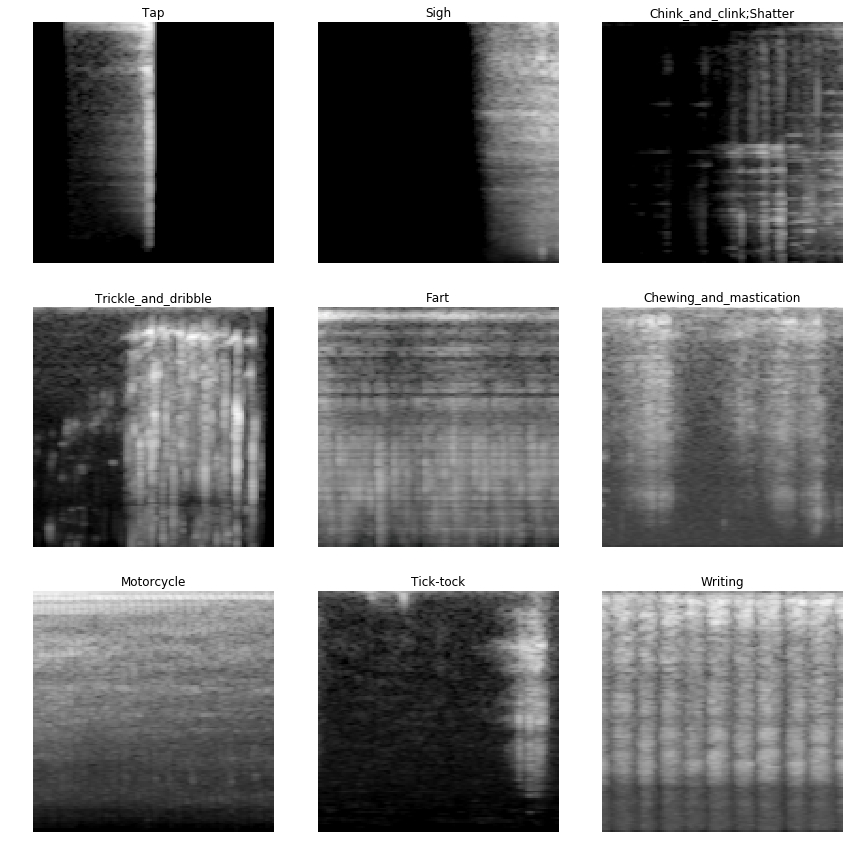

In [8]:
data.show_batch(3)

In [9]:
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[f_score])
learn.unfreeze()

In [10]:
learn.fit_one_cycle(5, slice(1e-6, 1e-1))

epoch,train_loss,valid_loss,fbeta,time
0,0.203528,0.081012,0.002012,00:07
1,0.105800,0.079637,0.033710,00:06
2,0.085251,0.070301,0.050444,00:06
3,0.074352,0.062099,0.038577,00:06
4,0.066430,0.059275,0.062867,00:07


In [11]:
learn.fit_one_cycle(100, slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,fbeta,time
0,0.062186,0.059096,0.052609,00:06
1,0.062219,0.058764,0.056816,00:06
2,0.061567,0.057757,0.079674,00:06
3,0.061374,0.057841,0.076148,00:06
4,0.060953,0.057789,0.064245,00:06
5,0.060162,0.056719,0.083029,00:06
6,0.060086,0.056581,0.083521,00:06
7,0.059886,0.056386,0.091169,00:07
8,0.059226,0.079063,0.099661,00:07
9,0.058571,0.073271,0.130238,00:06


# Visualize Activation Map

Let's check where model is looking...

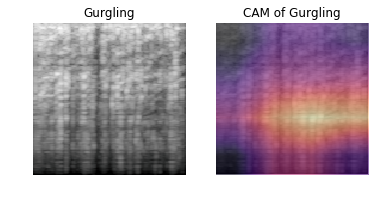

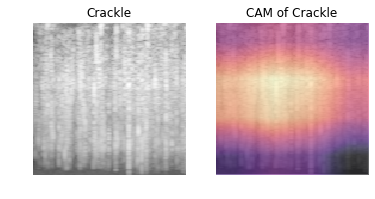

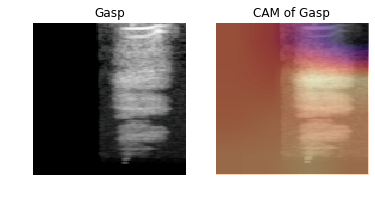

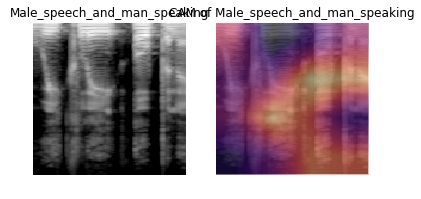

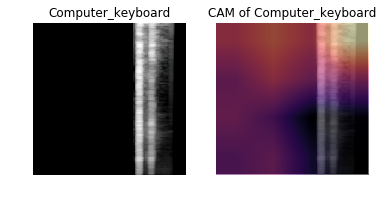

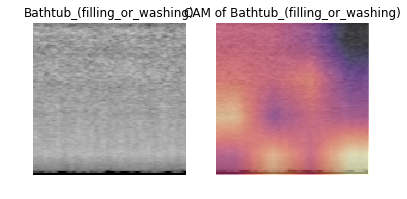

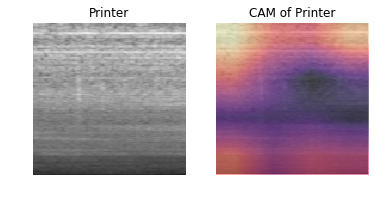

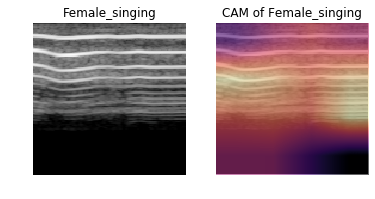

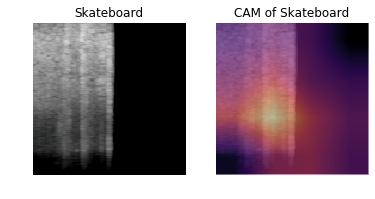

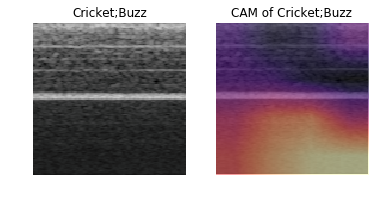

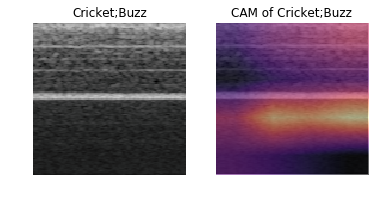

In [12]:
# Thanks to https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_cam(learn, idx)

## Is this model Sound?

If heat map is on the sound part, it would be good. But you might find some shows heat map is on the empty spaces, it would be showing that model is classfying because the silence is similar to training samples...

## What about the First Layer?

Here's quoting from (CS231n Convolutional Neural Networks for Visual Recognition)[http://cs231n.github.io/understanding-cnn/],

_"The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting."_

So let's visualize it also.

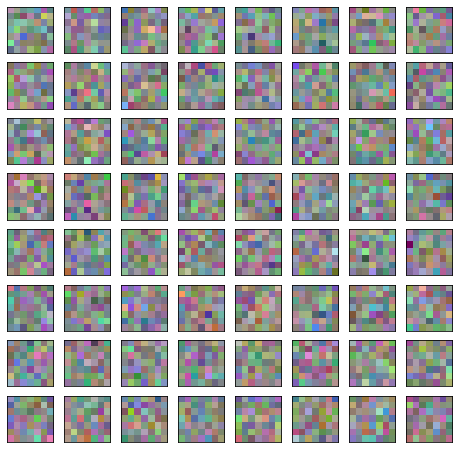

In [14]:
# https://discuss.pytorch.org/t/how-to-visualize-the-actual-convolution-filters-in-cnn/13850
from sklearn.preprocessing import minmax_scale

def visualize_first_layer(learn):
    conv1 = list(learn.model.children())[0][0]
    weights = conv1.weight.data.cpu().numpy()
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

visualize_first_layer(learn)

Oooops, too noisy! orz